# cuda:4

In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
torch.set_num_threads(4)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:7'

FREERUN = 1000
Ns = 20000+FREERUN
signal = signalz.mackey_glass(Ns, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1)
signal = signal - np.mean(signal)
print(f'\nsignal mean={np.mean(signal)}')
M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 300
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST

SIGNUM = 2      
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD = np.std(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal Length M = {M}')
print(f'minmax = {MINMAX}')
print(f'std = {STD}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0

signal mean=-6.580979147873308e-17
Signal Length M = 20000
minmax = 1.611402028919085
std = 0.3429382374043401


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

In [4]:
fpath = 'Dicts/diag_MG.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())
    
fpath = 'Dicts/diag_MG_sm.json'
with open(fpath,'r') as j:
    dict_diag_sm = json.loads(j.read())

fpath = 'Dicts/diag_MG_sm26.json'
with open(fpath,'r') as j:
    dict_diag_sm26 = json.loads(j.read())

In [5]:
fpath = 'Dicts/models_MG.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

fpath = 'Dicts/models_MG_sm.json'
with open(fpath,'r') as j:
    dict_models_sm = json.loads(j.read())

fpath = 'Dicts/models_MG_sm26.json'
with open(fpath,'r') as j:
    dict_models_sm26 = json.loads(j.read())
dict_diag = {**dict_diag,
             **dict_diag_sm,
             **dict_diag_sm26}
dict_models = {**dict_models,
               **dict_models_sm,
               **dict_models_sm26}

In [6]:
dict_diag

{'300': {'numModels': 119,
  'meanError': 0.12216539855717959,
  'varError': 0.0026499126683385337},
 '50': {'numModels': 117,
  'meanError': 0.1678303964029894,
  'varError': 0.002516993094247331},
 '40': {'numModels': 118,
  'meanError': 0.17220349071479654,
  'varError': 0.003065441805755812},
 '30': {'numModels': 110,
  'meanError': 0.17287231786504825,
  'varError': 0.002913235208636308},
 '10': {'numModels': 116,
  'meanError': 0.1958487602463504,
  'varError': 0.0009628015501614066},
 '20': {'numModels': 1, 'meanError': 0.09064845436360582, 'varError': 0.0},
 '28': {'numModels': 6,
  'meanError': 0.08748978853871657,
  'varError': 4.613254148742115e-05},
 '26': {'numModels': 3,
  'meanError': 0.09500544357938963,
  'varError': 1.4161299561176094e-05},
 '24': {'numModels': 2,
  'meanError': 0.0867681759510319,
  'varError': 9.453169035339677e-05},
 '22': {'numModels': 0, 'meanError': nan, 'varError': nan},
 '18': {'numModels': 1, 'meanError': 0.09741977827069086, 'varError': 0.0}

In [7]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

N=300   Error = 0.043129 KL-div = 0.509
N=50   Error = 0.061613 KL-div = 1.016
N=40   Error = 0.061269 KL-div = 0.703
N=30   Error = 0.053659 KL-div = 0.574
N=20   Error = 0.090648 KL-div = 1.370
N=10   Error = 0.131008 KL-div = 1.152
N=28   Error = 0.079568 KL-div = 0.765
N=26   Error = 0.089751 KL-div = 0.729
N=24   Error = 0.077045 KL-div = 0.635
N=18   Error = 0.097420 KL-div = 1.373


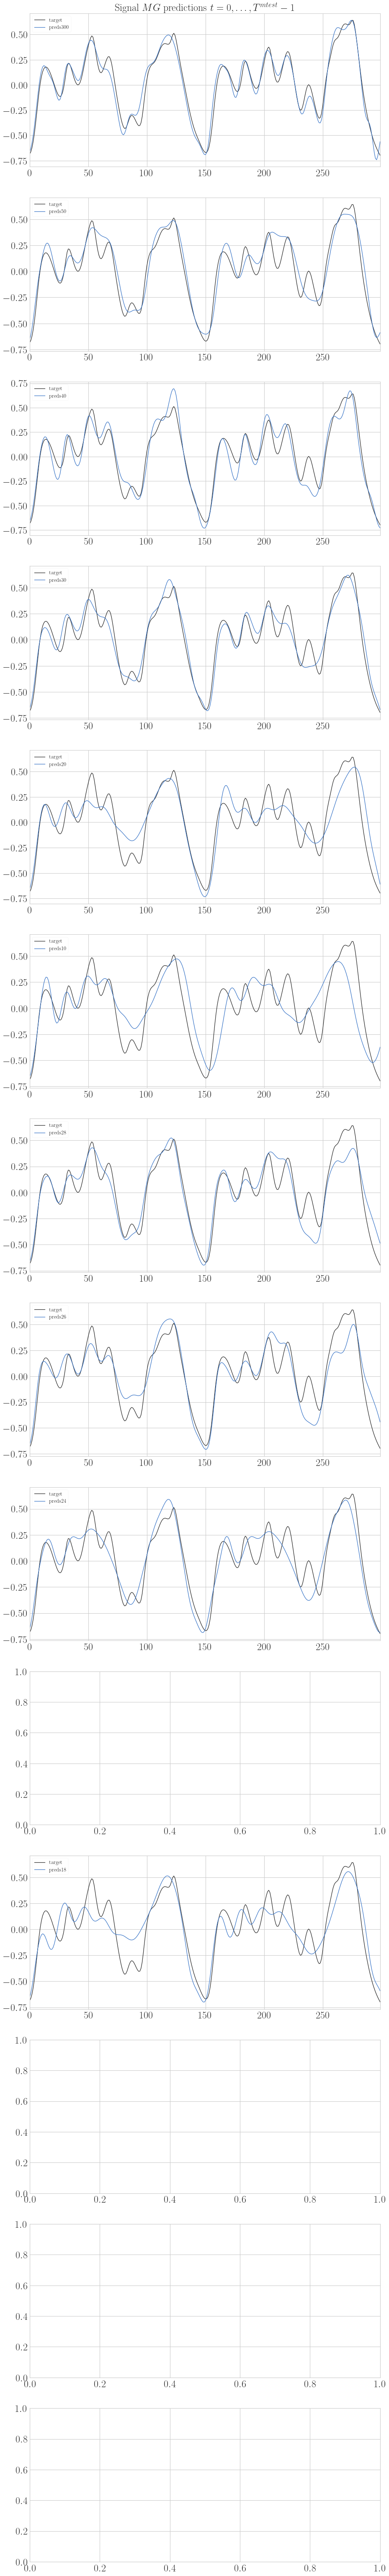

In [8]:
size = [300, 50, 40, 30, 20, 10, 28, 26, 24, 22, 18, 16, 14, 12]

Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
axs[0].set_title('Signal $MG$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    if(dict_diag[str(size[n])]['numModels']==0):
        continue
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    preds = dict_models[str(size[n])]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    print(f'N={size[n]}   Error = {error_testset:3f} KL-div = {kl:.3f}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### Get indicated rank to reduce to

Alpha 0.5210345659934661 --- Gamma 1.0
Targeted reduced rank for N=300 is 173
Value v= 15 Tolerance 1e-15 Rho A 1.032
Alpha 0.5210345659934661 --- Gamma 1.0

Alpha 0.41898399763542715 --- Gamma 1.0
Targeted reduced rank for N=50 is 45
Value v= 16 Tolerance 1e-16 Rho A 1.064
Alpha 0.41898399763542715 --- Gamma 1.0

Alpha 0.5385179276034887 --- Gamma 1.0
Targeted reduced rank for N=40 is 38
Value v= 16 Tolerance 1e-16 Rho A 1.057
Alpha 0.5385179276034887 --- Gamma 1.0

Alpha 0.5161615366581096 --- Gamma 1.0
Targeted reduced rank for N=30 is 28
Value v= 16 Tolerance 1e-16 Rho A 1.036
Alpha 0.5161615366581096 --- Gamma 1.0

Alpha 0.5273452886561393 --- Gamma 1.0
Targeted reduced rank for N=20 is 2
Value v= 0 Tolerance 1.0 Rho A 1.017
Alpha 0.5273452886561393 --- Gamma 1.0

Alpha 0.46402056183002605 --- Gamma 1.0
Targeted reduced rank for N=10 is 3
Value v= 0 Tolerance 1.0 Rho A 1.073
Alpha 0.46402056183002605 --- Gamma 1.0

Alpha 0.4753683290461202 --- Gamma 1.0
Targeted reduced rank for N

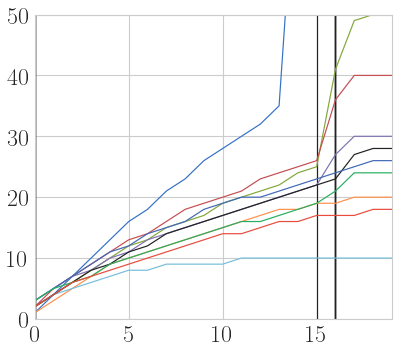

In [9]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

K = 1
L = 1
tols = [1/10**x for x in range(0,20)]
plt.figure()
for i in range(Nplots):
    n = size[i]
    if(dict_diag[str(n)]['numModels']==0):
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    print(f'Alpha {a} --- Gamma {g}')
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    #print(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
    print(f'Alpha {a} --- Gamma {g}\n')
plt.ylim(0,50)
plt.show()

### Get time-step of divergence as measured by $R_{\mathbf{xy}}[k]$ correlation at each $t$### Get divergence

In [10]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
FREE =1000
T = M + FREE
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(Nsizes):
    if(dict_diag[str(size[i])]['numModels']==0):
        continue
    k = size[i]
    corr_length = T-k # calculate for j= 0,..., M-k
    pred = np.array(dict_models[str(k)]['Preds']) # Get size N predictions
    
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,TRAINLENGTH-1000:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k-size={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')


k-size=300 Trainingset min=0.977  threshold=0.928  Location=231
k-size=50 Trainingset min=0.948  threshold=0.901  Location=155
k-size=40 Trainingset min=0.933  threshold=0.887  Location=4
k-size=30 Trainingset min=0.92  threshold=0.874  Location=4
k-size=20 Trainingset min=0.923  threshold=0.876  Location=7
k-size=10 Trainingset min=0.788  threshold=0.748  Location=19
k-size=28 Trainingset min=0.919  threshold=0.873  Location=16
k-size=26 Trainingset min=0.91  threshold=0.864  Location=4
k-size=24 Trainingset min=0.915  threshold=0.870  Location=8
k-size=18 Trainingset min=0.902  threshold=0.857  Location=1


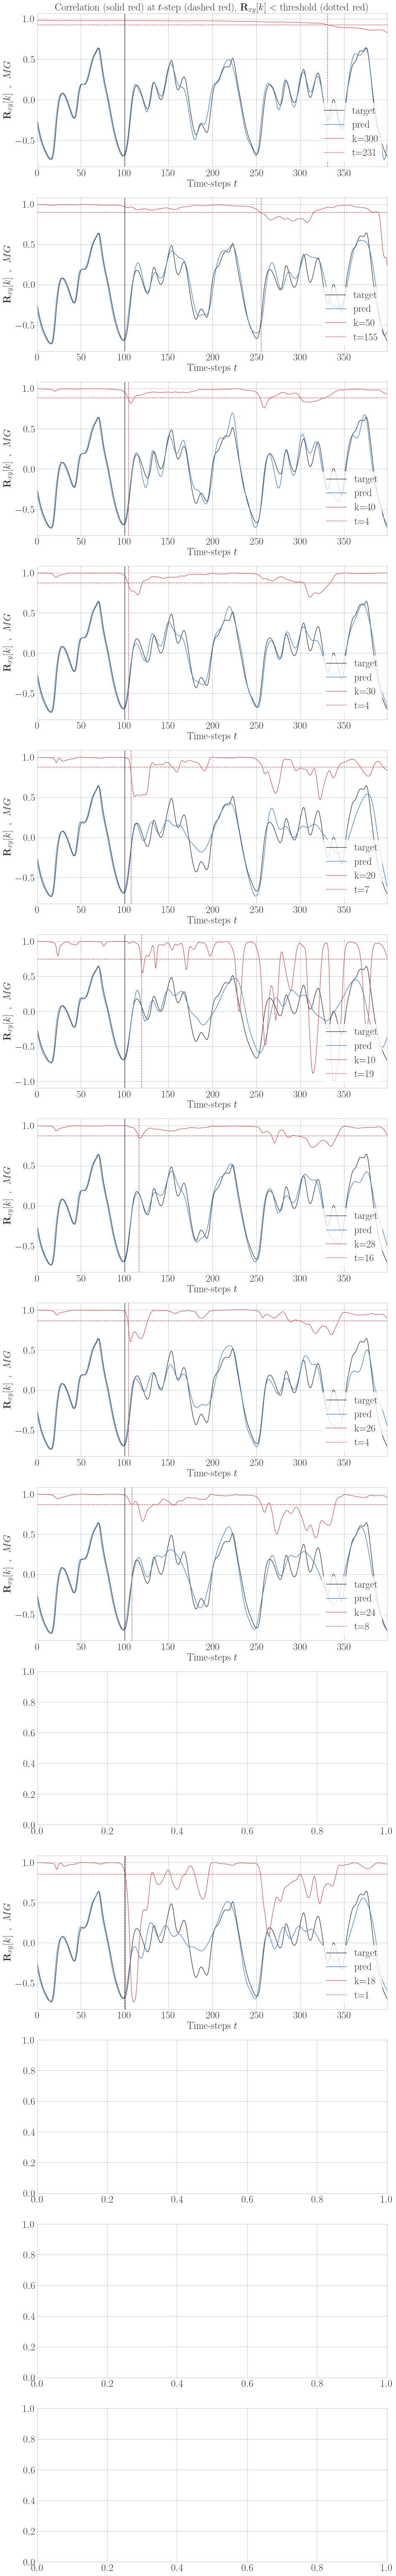

In [11]:
LEAD = 100
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    if(dict_diag[str(size[n])]['numModels']==0):
        continue
    pred = dict_models[str(size[n])]['Preds']
    axs[n].plot(signal[TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='k', label='target')
    axs[n].plot(pred[TRAINLENGTH-LEAD:TRAINLENGTH+TEST],color='b', label='pred')
    axs[n].plot(correlations[n,TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='r', label=f'k={size[n]}')
    axs[n].axvline(LEAD+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(LEAD,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dashed')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace MG$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()

### Chaos plot

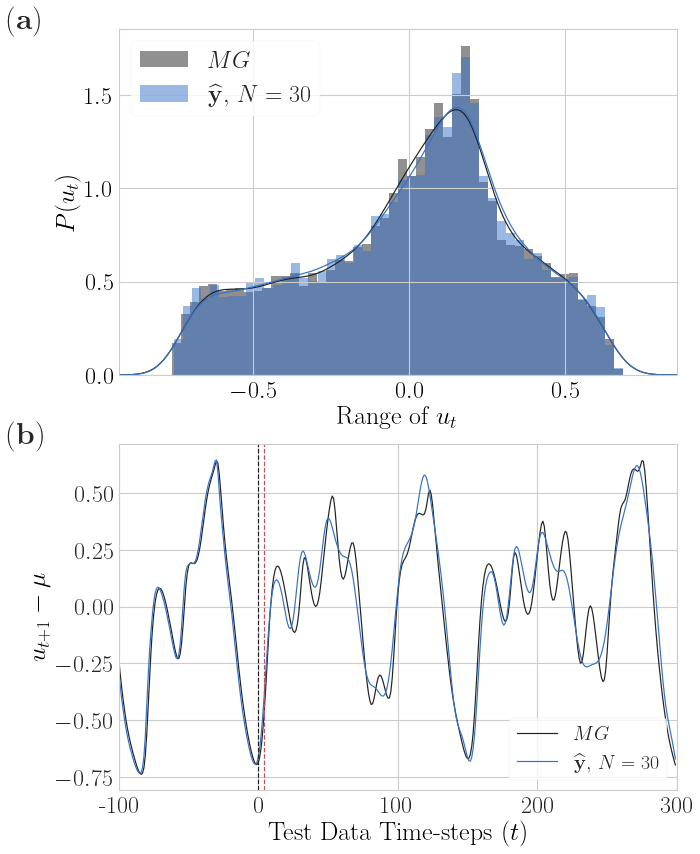

In [12]:
import seaborn as sns
import pandas as pd
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii




n=30
pred = np.array(dict_models[str(n)]['Preds'])
data_dict = {'y': signal[14000:],
             'yh': np.squeeze(pred[14000:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
fig= plt.figure(figsize=(10,14))
ax1 = plt.subplot(211)
sns.distplot(df['y'],
             label='$MG$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
sns.distplot(df['yh'],
             label='$\widehat{\mathbf{y}},\,N=30$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
plt.legend(loc='upper left', fontsize=fontsize)
plt.ylabel(r'${P}(u_t)$', fontsize=26,  color='black', weight='heavy')
plt.xlabel(r'Range of $u_t$', fontsize=26,  color='black', weight='heavy')
plt.xticks(c='black', fontsize=fontsize)
plt.yticks(c='black', fontsize=fontsize)
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')

ax2 = plt.subplot(212)
plt.rcParams['xtick.major.pad']='8'
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.plot(signal[TRAINLENGTH-100:TRAINLENGTH+TEST],'k', label=r'$MG$')
ax2.plot(pred[TRAINLENGTH-100:TRAINLENGTH+TEST],'b-', label='$\widehat{\mathbf{y}},\,N=30$')
ax2.axvline(100, c='k',ls='dashed' )
ax2.axvline(100+threshold_location[3], c='r',ls='dashed' )
ax2.legend(loc='lower right',fontsize=20)
ax2.set_xticks([0,100,200,300,400])
ax2.set_xticklabels([-100,0,100,200,300])
ax2.set_xlabel('Test Data Time-steps '+'($t$)', fontsize=26, color='black', weight='heavy')
ax2.set_ylabel(r'${u_{t+1} - \mu}$', fontsize=26, color='black', weight='heavy')

plt.show()